In [90]:
# Imports
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# Exploratory Data Analysis

### Loading Dataset:

In [91]:
file_path = 'Dataset/train_features.csv'
df = pd.read_csv(file_path)

In [92]:
def saveDataset(file_path):
    df.to_csv(file_path, index=False, encoding='utf-8')

### Exploring Dataset Features & Values:

#### 1) Column types & unique values

In [93]:
print(df.shape)
summary = []

for col in df.columns:
    dtype = df[col].dtype
    unique_vals = df[col].nunique()
    
    # Get range if numeric
    if pd.api.types.is_numeric_dtype(df[col]):
        col_min = df[col].min()
        col_max = df[col].max()
        value_range = f'{col_min} to {col_max}'
    else:
        value_range = 'Object'
    
    summary.append({
        'Column': col,
        'Data Type': dtype,
        'Unique Values': unique_vals,
        'Value Range': value_range
    })

# Convert to DataFrame for nice display
summary_df = pd.DataFrame(summary)

# Show the full summary
print(summary_df)

(1749494, 57)
                           Column Data Type  Unique Values        Value Range
0                     building_id     int64            200          1 to 1353
1                       timestamp    object           8784             Object
2                   meter_reading   float64         191681     0.0 to 6596.89
3                         anomaly     int64              2             0 to 1
4                         site_id     int64             14            0 to 15
5                     primary_use    object             12             Object
6                     square_feet     int64            200      898 to 484376
7                      year_built     int64             32           0 to 255
8                     floor_count     int64             12            0 to 12
9                 air_temperature   float64            620      -29.9 to 47.2
10                 cloud_coverage     int64             11           0 to 255
11                dew_temperature   float64       

We can see some features like `gte_meter` and `year` have only 1 unique value, let's drop them

In [94]:
df.drop(columns=['gte_meter', 'year'], inplace=True)
print(df.shape)

(1749494, 55)


#### 2) Feature Type Relations

In [95]:
object_columns = df.select_dtypes(include='object').columns.to_list()
print(object_columns, '\n')

sample_columns = ['hour', 'weekday', 'weekday_hour'] 
print(df[sample_columns].head(), '\n')

sample_columns = ['hour', 'hour_x', 'hour_y'] 
print(df[sample_columns][df['hour'] != 0][:5], '\n')

sample_columns = ['month', 'month_x', 'month_y'] 
print(df[sample_columns][df['month'] != 0][:5], '\n')

sample_columns = ['weekday', 'weekday_x', 'weekday_y'] 
print(df[sample_columns][df['weekday'] != 0][:5], '\n')

sample_columns = ['weekday', 'hour', 'weekday_hour'] 
print(df[sample_columns][df['hour'] != 0][:5], '\n')

sample_columns = ['building_id', 'weekday', 'building_weekday', 'weekday_hour', 'building_weekday_hour', 'month', 'building_month'] 
print(df[sample_columns][df['hour'] != 0][:5], '\n')

['timestamp', 'primary_use', 'weekday_hour', 'building_weekday_hour', 'building_weekday', 'building_month', 'building_hour', 'building_meter'] 

   hour  weekday weekday_hour
0     0        4          4-0
1     0        4          4-0
2     0        4          4-0
3     0        4          4-0
4     0        4          4-0 

     hour  hour_x  hour_y
200     1   0.966   0.259
201     1   0.966   0.259
202     1   0.966   0.259
203     1   0.966   0.259
204     1   0.966   0.259 

   month  month_x  month_y
0      1      1.0      0.0
1      1      1.0      0.0
2      1      1.0      0.0
3      1      1.0      0.0
4      1      1.0      0.0 

   weekday  weekday_x  weekday_y
0        4        1.0        0.0
1        4        1.0        0.0
2        4        1.0        0.0
3        4        1.0        0.0
4        4        1.0        0.0 

     weekday  hour weekday_hour
200        4     1          4-1
201        4     1          4-1
202        4     1          4-1
203        4     1     

1) We can see that features like `hour`, `day`, `week`, `year`, `hour_x`, ... are just an expanded form of `timestamp` feature, so we can remove it
2) Also, features like `building_weekday`, `building_...` are just compination of `building_id` and features mentioned in 1, so we can also remove them

In [96]:
columns = ['timestamp', 'weekday_hour', 'building_weekday_hour', 'building_weekday', 'building_month', 'building_hour', 'building_meter']
df.drop(columns=columns, inplace=True)
print(df.shape)

(1749494, 48)


#### 3) Null/Missing Values

In [97]:
null_counts = df.isnull().sum()
data_types = df.dtypes

summary = pd.DataFrame({
    'Null Values': null_counts,
    'Data Type': data_types
})

print(summary)

                               Null Values Data Type
building_id                              0     int64
meter_reading                       107653   float64
anomaly                                  0     int64
site_id                                  0     int64
primary_use                              0    object
square_feet                              0     int64
year_built                               0     int64
floor_count                              0     int64
air_temperature                          0   float64
cloud_coverage                           0     int64
dew_temperature                          0   float64
precip_depth_1_hr                        0     int64
sea_level_pressure                       0   float64
wind_direction                           0     int64
wind_speed                               0   float64
air_temperature_mean_lag7                0   float64
air_temperature_max_lag7                 0   float64
air_temperature_min_lag7                 0   f

Only feature `meter_reading` has null values, lets explore those values

In [98]:
null_df = df[df['meter_reading'].isnull()]

# Analyze other columns
summary = []

for col in null_df.columns:
    if col == 'meter_reading':
        continue  

    dtype = null_df[col].dtype
    unique_vals = null_df[col].nunique()
    
    if pd.api.types.is_numeric_dtype(null_df[col]):
        col_min = null_df[col].min()
        col_max = null_df[col].max()
        value_range = f'{col_min} to {col_max}'
    else:
        value_range = 'object'
    
    summary.append({
        'Column': col,
        'Data Type': dtype,
        'Unique Values': unique_vals,
        'Value Range': value_range
    })

# Convert to summary DataFrame
summary_df = pd.DataFrame(summary)
print(summary_df)

                           Column Data Type  Unique Values        Value Range
0                     building_id     int64            177          1 to 1323
1                         anomaly     int64              1             0 to 0
2                         site_id     int64             12            0 to 14
3                     primary_use    object             11             object
4                     square_feet     int64            177      898 to 484376
5                      year_built     int64             28           0 to 255
6                     floor_count     int64             12            0 to 12
7                 air_temperature   float64            383      -29.9 to 42.2
8                  cloud_coverage     int64             10           0 to 255
9                 dew_temperature   float64            310      -36.0 to 26.1
10              precip_depth_1_hr     int64             62          -2 to 343
11             sea_level_pressure   float64            608    96

We can see that all rows that has `meter_reading` as null are not anomalous (`anamoly` = 0), and we have a lot of other data samples.  
So let's just drop these null values

In [99]:
df.dropna(inplace=True)
print(df['meter_reading'].isnull().sum())
print(df.shape)

0
(1641841, 48)


#### 4) Handling non-numeric Features

In [100]:
non_numeric_cols = df.select_dtypes(exclude=['number']).columns
print(non_numeric_cols.tolist())

['primary_use']


`primary_use` feature need to be converted to numeric values

We will use One Hot Encoding

In [101]:
unique_vals = df['primary_use'].unique().astype(str)
length = len(unique_vals)
print(unique_vals, '\n')
df = pd.get_dummies(df, columns=['primary_use'], drop_first=True)
print(df.shape)

['Education' 'Entertainment/public assembly' 'Public services' 'Office'
 'Lodging/residential' 'Manufacturing/industrial' 'Other' 'Services'
 'Parking' 'Healthcare' 'Food sales and service' 'Religious worship'] 

(1641841, 58)


In [102]:
print(df.select_dtypes(exclude=['number']).columns.tolist())
print(df['primary_use_Entertainment/public assembly'].dtype)
print(df.shape)

['primary_use_Entertainment/public assembly', 'primary_use_Food sales and service', 'primary_use_Healthcare', 'primary_use_Lodging/residential', 'primary_use_Manufacturing/industrial', 'primary_use_Office', 'primary_use_Other', 'primary_use_Parking', 'primary_use_Public services', 'primary_use_Religious worship', 'primary_use_Services']
bool
(1641841, 58)


In [103]:
columns = ['primary_use_Entertainment/public assembly', 'primary_use_Food sales and service', 'primary_use_Healthcare', 'primary_use_Lodging/residential', 'primary_use_Manufacturing/industrial', 'primary_use_Office', 'primary_use_Other', 'primary_use_Parking', 'primary_use_Public services', 'primary_use_Religious worship', 'primary_use_Services']
df[columns] = df[columns].astype(int)
print(df.select_dtypes(exclude=['number']).columns.tolist())

[]


#### 5) Features Correlations

We need to see if there are features that contains redundant information in the dataset, those won't be helpful for the model  

Also, there are features that are generated from other features like `gte_meter_...`, `gte_...`, `air_temperature_..._lag7`, `air_temperature_..._lag73`
These were used by different participants in the kaggle competetion, let's see if they are highly correlated with other features

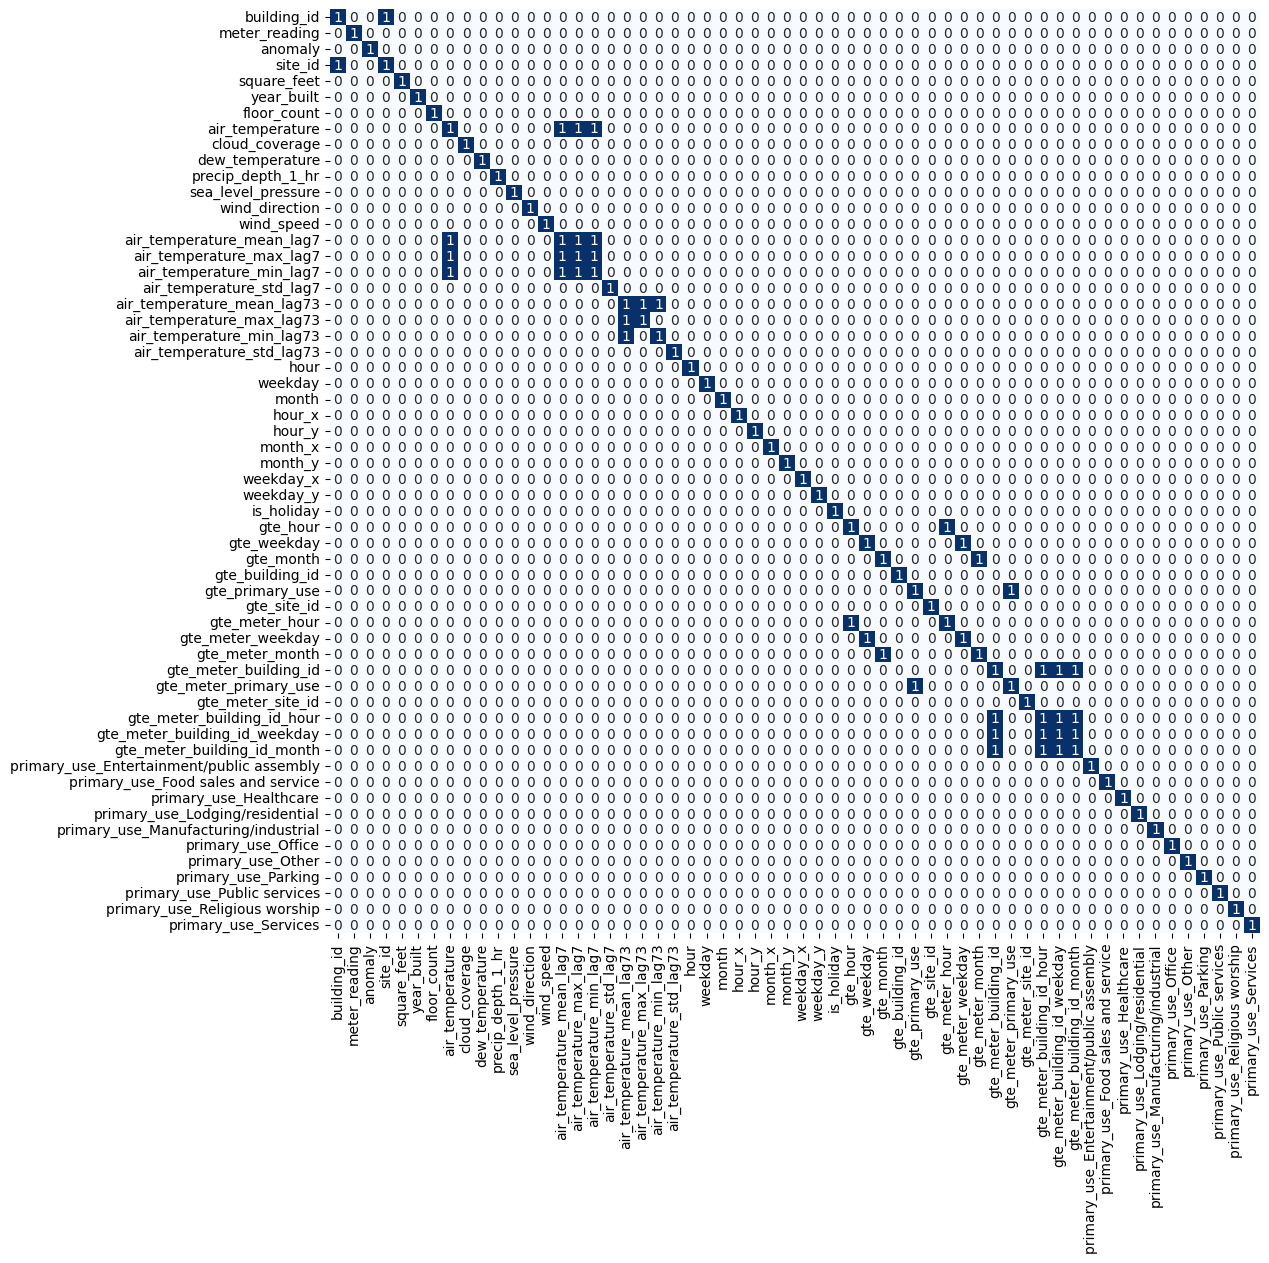

In [104]:
correlation_matrix = df.corr()
plt.figure(figsize=(12, 12))

sns.heatmap(abs(correlation_matrix) > 0.96, annot= True, cbar= False, cmap= 'Blues')

plt.show()

- We can see that the generated features are very highly correlated:  

    - Features `air_temperature_mean_lag7`, `air_temperature_max_lag7`, `air_temperature_min_lag7` are highly correlated with `air_temperature`, so let's keep `air_temperature` and remove the others.

    - Features `air_temperature_mean_lag73`, `air_temperature_max_lag73`, `air_temperature_min_lag73` are highly correlated with each other and `air_temperature`, so let's remove them. 

    - Features `gte_meter_building_id_hour`, `gte_meter_building_id_weekday`, `gte_meter_building_id_month` are highly correlated with each other and `gte_meter_building_id`, so let's keep `gte_meter_building_id` and remove the others.  

    - Features `gte_meter_hour`, `gte_meter_month`, `gte_meter_weekday` are highly correlated with `gte_hour`, `gte_month`, `gte_weekday`, so they don't provide useful information and should be removed.

- Also, features `gte_building_id`, `gte_primary_use`, `gte_site_id`, `gte_meter_building_id`, `gte_meter_primary_use`, `gte_meter_site_id` 
are generated from `building_id`, `primary_use`, `site_id` and don't provide any useful information. We should remove them.

- Feature `building_id` is highly correlated with `site_id` but let's keep them both for now.

In [105]:
high_corr_features = [
 'gte_building_id', 'gte_primary_use', 'gte_site_id',
 'gte_meter_building_id', 'gte_meter_primary_use', 'gte_meter_site_id',
 'gte_meter_building_id_hour', 'gte_meter_building_id_weekday', 'gte_meter_building_id_month', 
 'gte_meter_hour', 'gte_meter_month', 'gte_meter_weekday',
 'air_temperature_mean_lag73', 'air_temperature_max_lag73', 'air_temperature_min_lag73',
 'air_temperature_mean_lag7', 'air_temperature_max_lag7', 'air_temperature_min_lag7'
]

df.drop(columns=high_corr_features, inplace=True)
print(df.shape)

(1641841, 40)


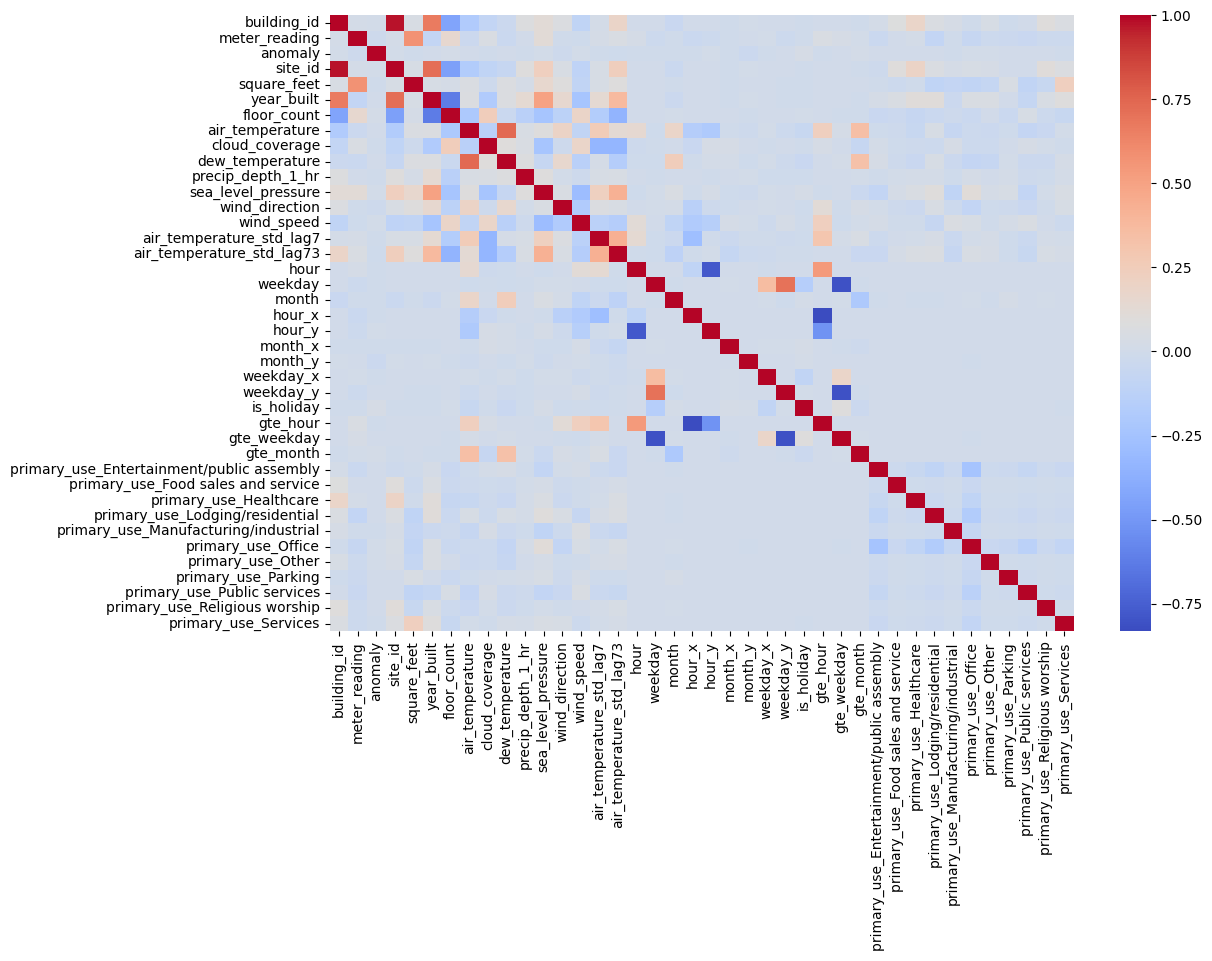

In [106]:
correlation_matrix = df.corr()
plt.figure(figsize=(12, 8))

sns.heatmap(correlation_matrix, annot= False, cmap= 'coolwarm')

plt.show()

#### 6) Outliers & Other Observations

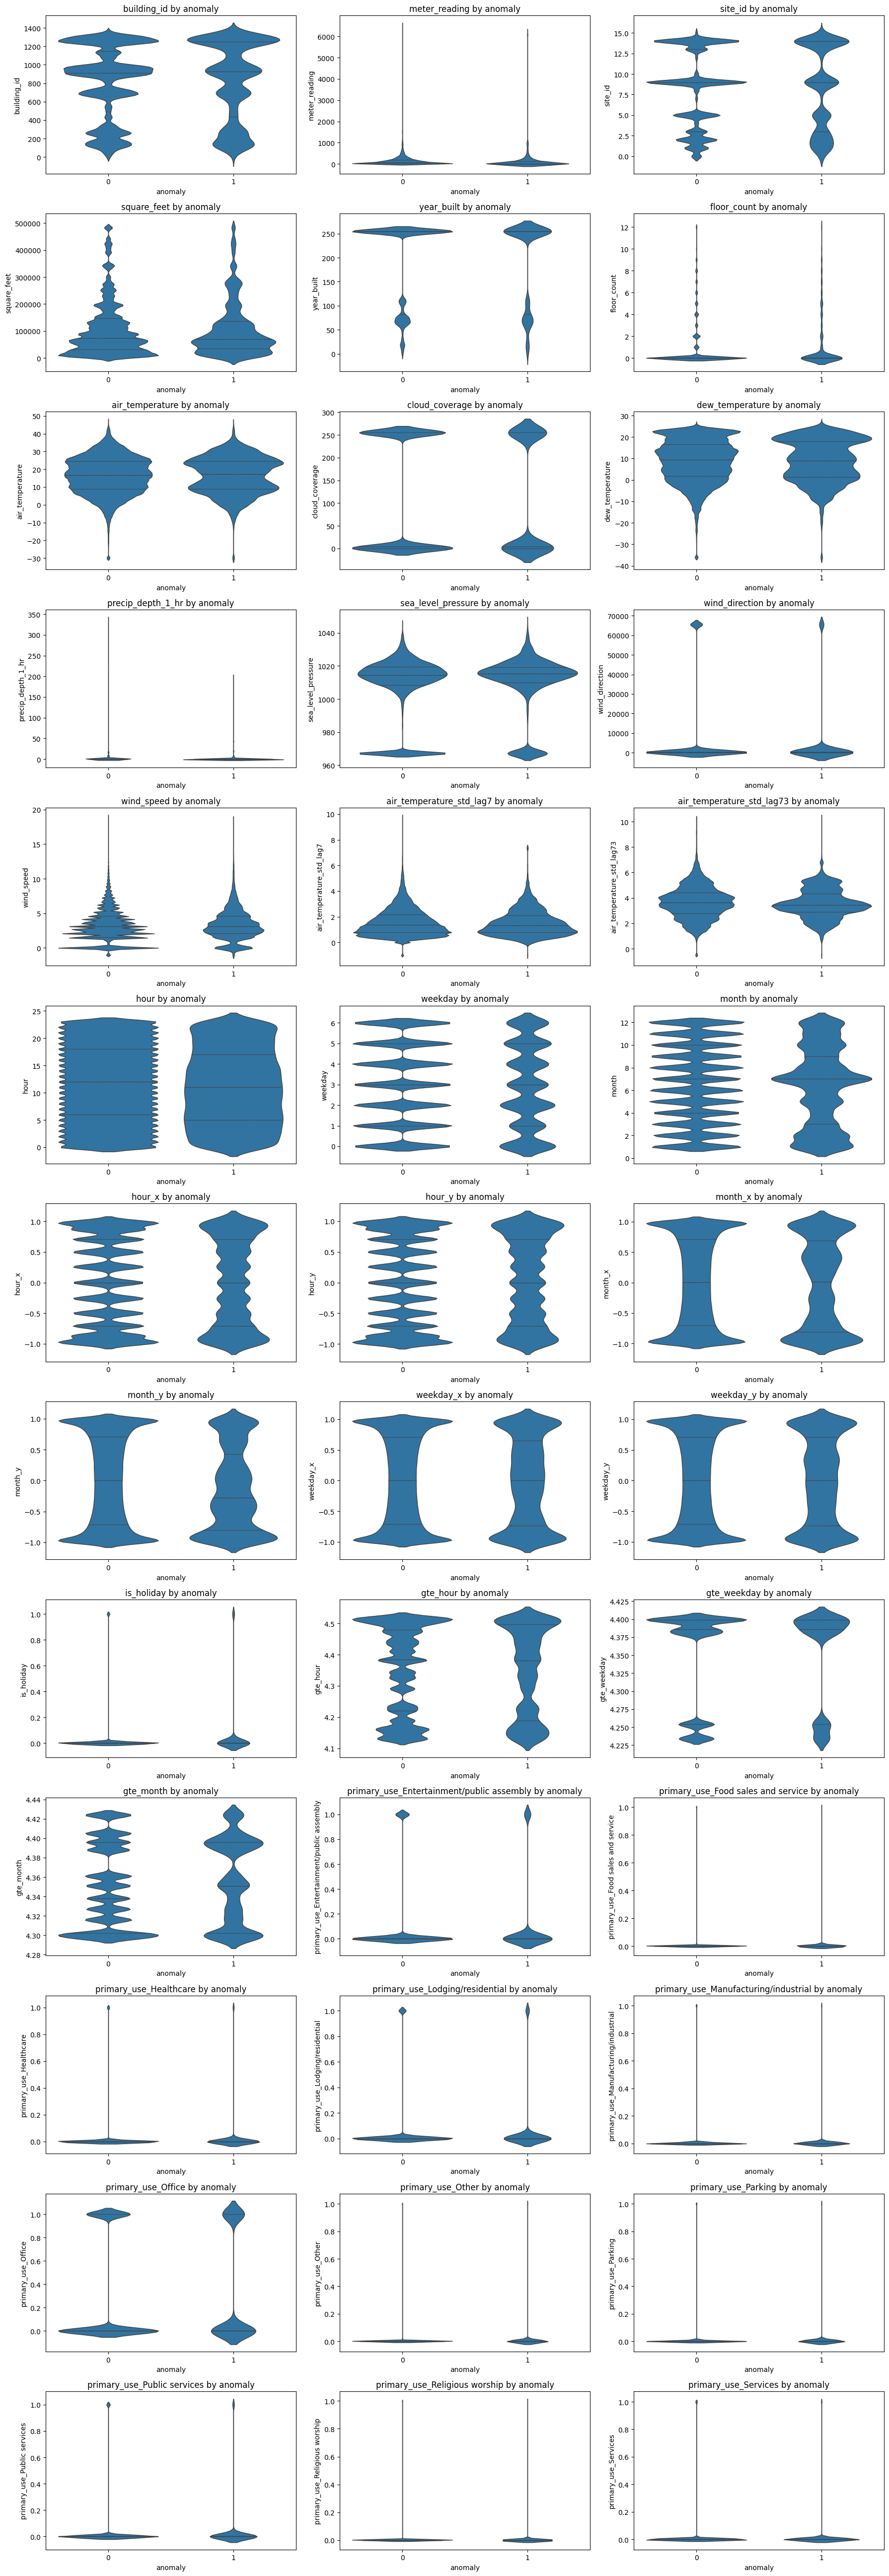

In [38]:
def showGraphs():
    target_col = 'anomaly' 
    feature_cols = [col for col in df.columns if col != target_col]

    n_cols = 3  # Number of plots per row
    n_rows = (len(feature_cols) + n_cols - 1) // n_cols

    plt.figure(figsize=(n_cols * 6, n_rows * 4))

    for idx, col in enumerate(feature_cols, 1):
        plt.subplot(n_rows, n_cols, idx)
        sns.violinplot(x=df[target_col], y=df[col], inner="quart", linewidth=1)
        plt.title(f'{col} by {target_col}')
        
    plt.tight_layout()
    plt.show()
    
showGraphs()

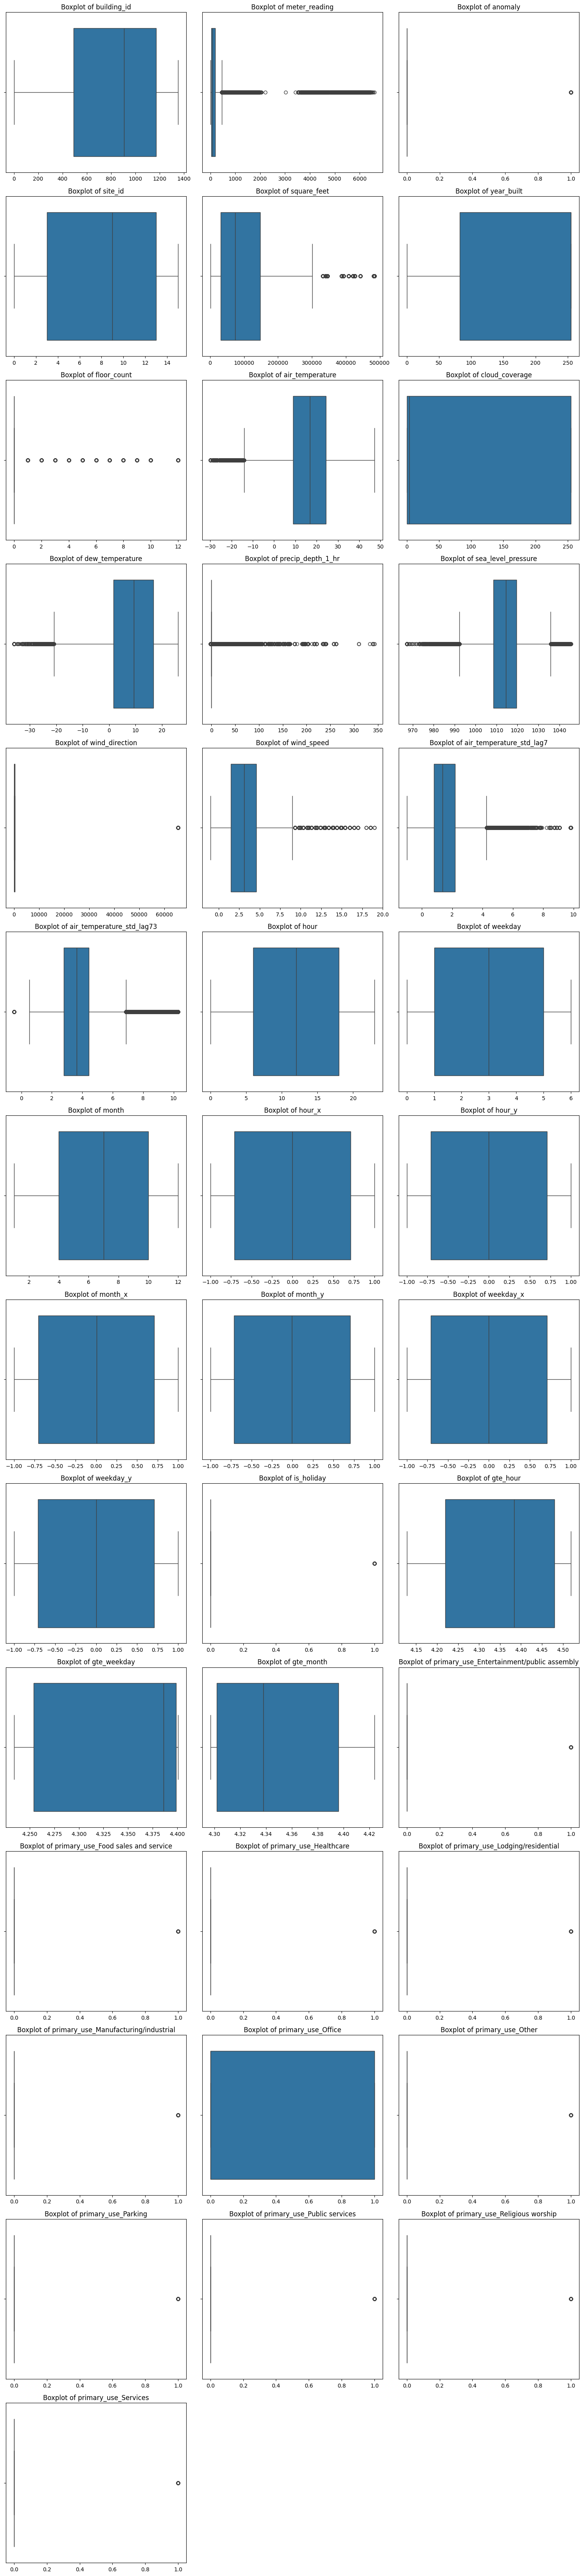

In [ ]:
num_cols = df.columns
n_cols = len(num_cols)

# Set number of plots per row
plots_per_row = 3

# Compute number of rows 
n_rows = (n_cols + plots_per_row - 1) // plots_per_row

plt.figure(figsize=(6 * plots_per_row, 5 * n_rows))

for i, col in enumerate(num_cols, 1):
    plt.subplot(n_rows, plots_per_row, i)
    sns.boxplot(x=df[col], color='skyblue')
    plt.title(f'Boxplot of {col}')
    plt.xlabel("")

plt.tight_layout()
plt.show()

We can see from the graphs that there are outliers in features: `meter_reading`, `year_built`, `cloud_coverage`, `percip_depth_1_hr`, `wind_direction`. Let's investigate further.

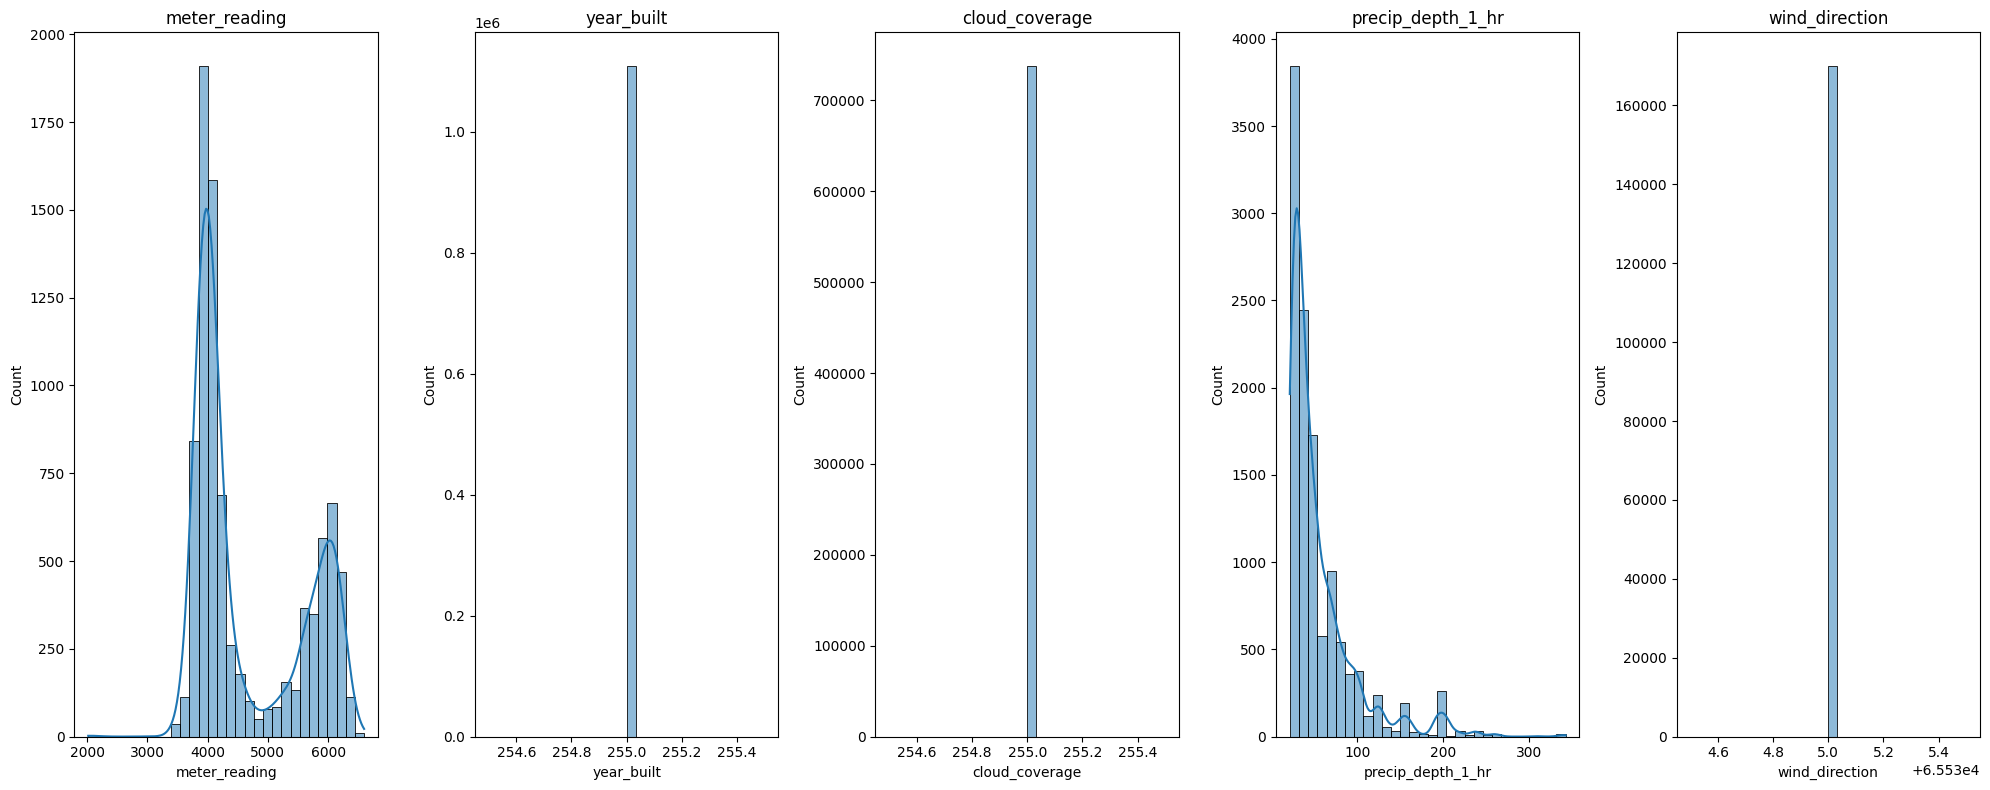

In [39]:
columns = ['meter_reading', 'year_built', 'cloud_coverage', 'precip_depth_1_hr', 'wind_direction']
outlier_values = [2000, 150, 50, 20, 10000]
plt.figure(figsize=(20, 8))
for idx, col in enumerate(columns, 0):
    plt.subplot(1, 5, idx + 1)
    sns.histplot(df[col][df[col] > outlier_values[idx]], bins=30, kde=True)
    plt.title(col)

plt.tight_layout()
plt.show()

We can see that:
- `cloud_coverage`, `wind_direction`, and `year_built` have a lot of outliers that needs to be handled.  
- `meter_reading` and `precip_depth_1_hr` outliers could contain useful information, so we will keep the outliers.

In [40]:
columns = ['year_built', 'cloud_coverage', 'wind_direction']
for col in columns:
    print(df[col].nunique())

32
11
44


For `wind_direction`, we can compress the large values of outliers using log

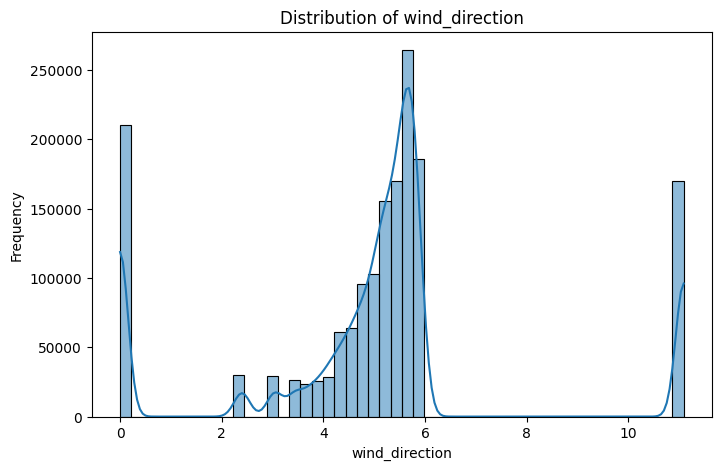

In [41]:
df['wind_direction'] = np.log1p(df['wind_direction']) # log(1 + x)
plt.figure(figsize=(8, 5))
sns.histplot(df['wind_direction'], bins=50, kde=True)
plt.title(f'Distribution of wind_direction')
plt.xlabel('wind_direction')
plt.ylabel('Frequency')
plt.show()

In [42]:
columns = ['year_built', 'cloud_coverage']
print('year_built: ', sorted(df[columns[0]].unique().tolist()), '\n')
print('cloud_coverage: ', sorted(df[columns[1]].unique().tolist()), '\n')

year_built:  [0, 6, 9, 13, 19, 30, 31, 45, 52, 57, 60, 64, 65, 66, 67, 68, 70, 74, 76, 77, 82, 89, 92, 100, 103, 104, 105, 107, 110, 111, 114, 255] 

cloud_coverage:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 255] 



For `year_built`, `cloud_coverage`:
- It seems value 255 is just a replacement for missing values
- Let's just drop them as we have many features and they don't have meaning related to energy consumption anyway

In [108]:
df.drop(columns=['year_built', 'cloud_coverage'], inplace=True)
print(df.shape)

(1641841, 38)


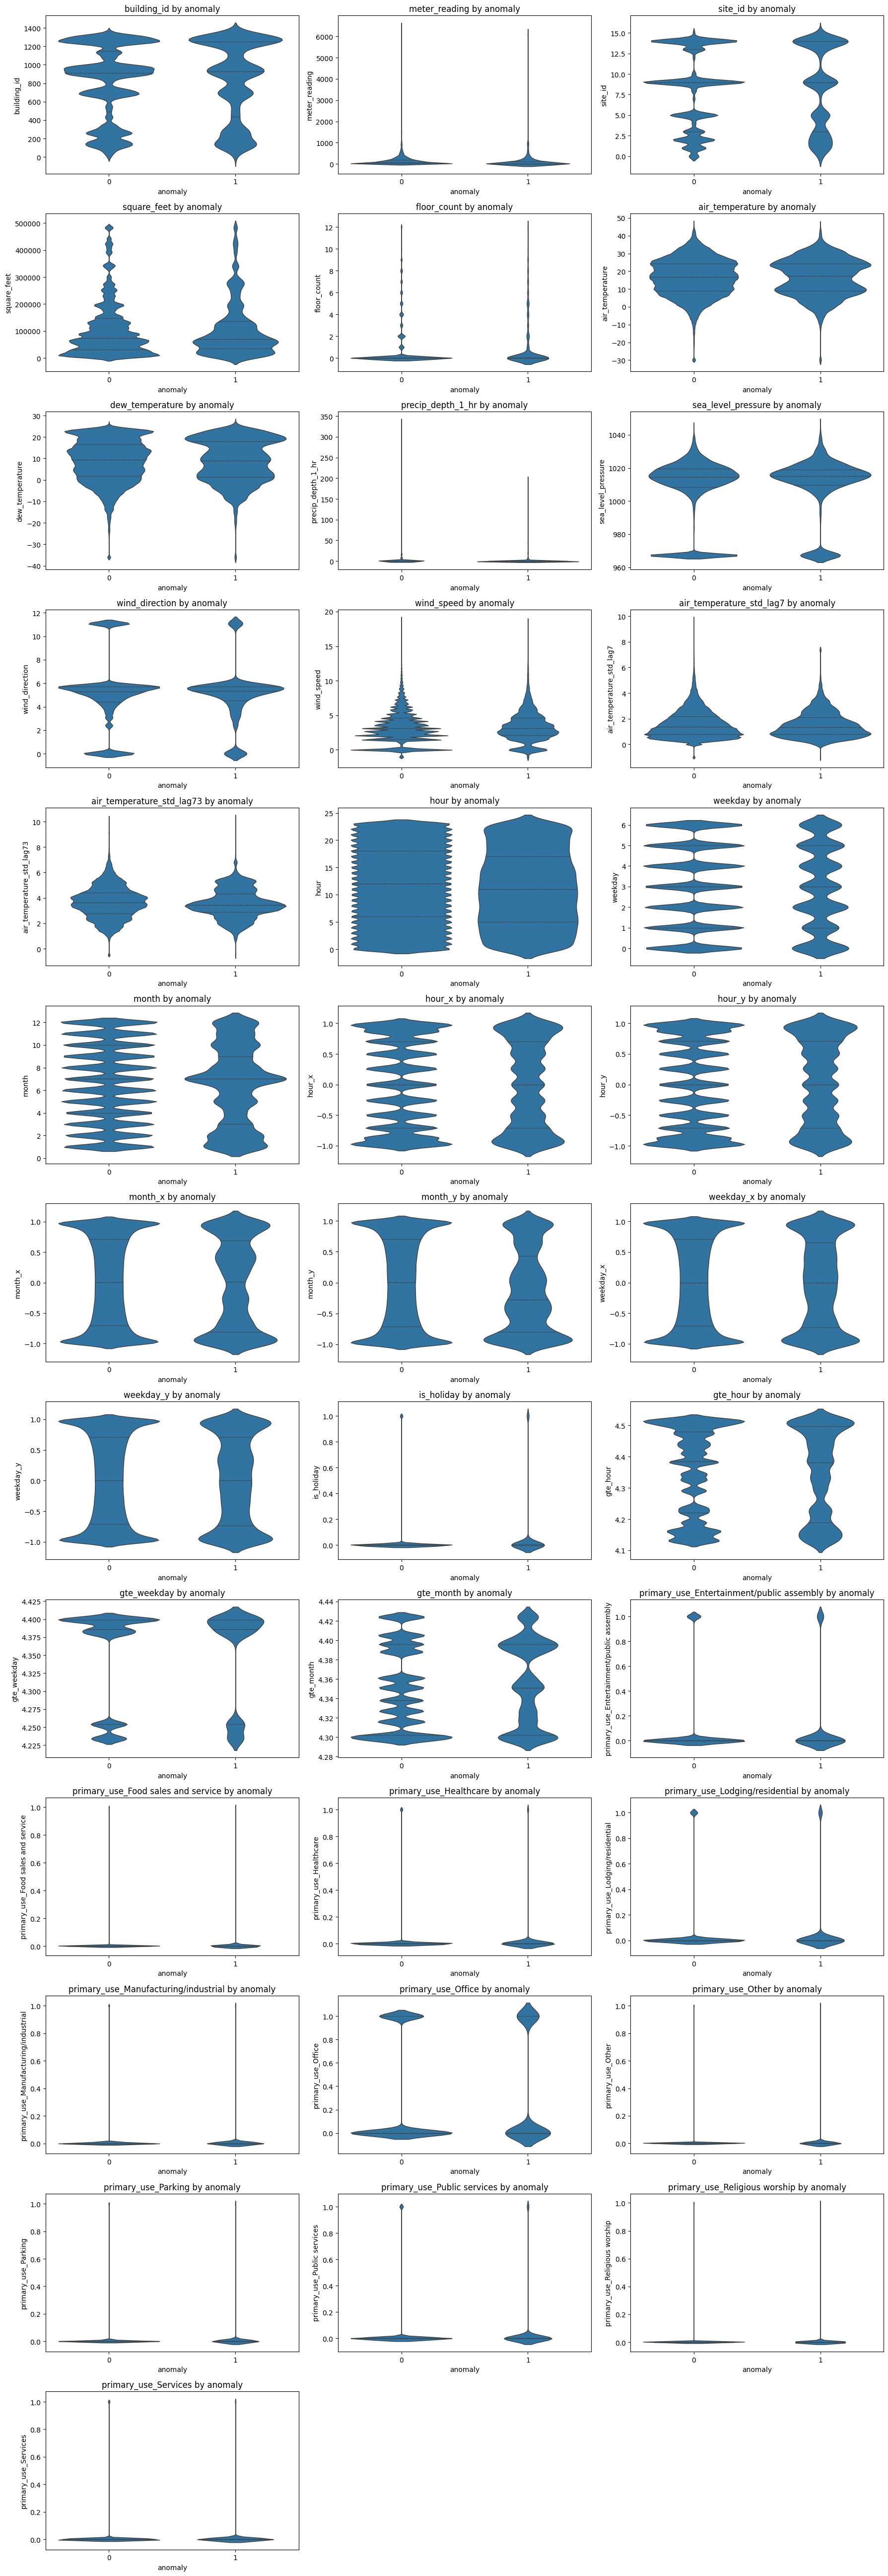

In [44]:
showGraphs()

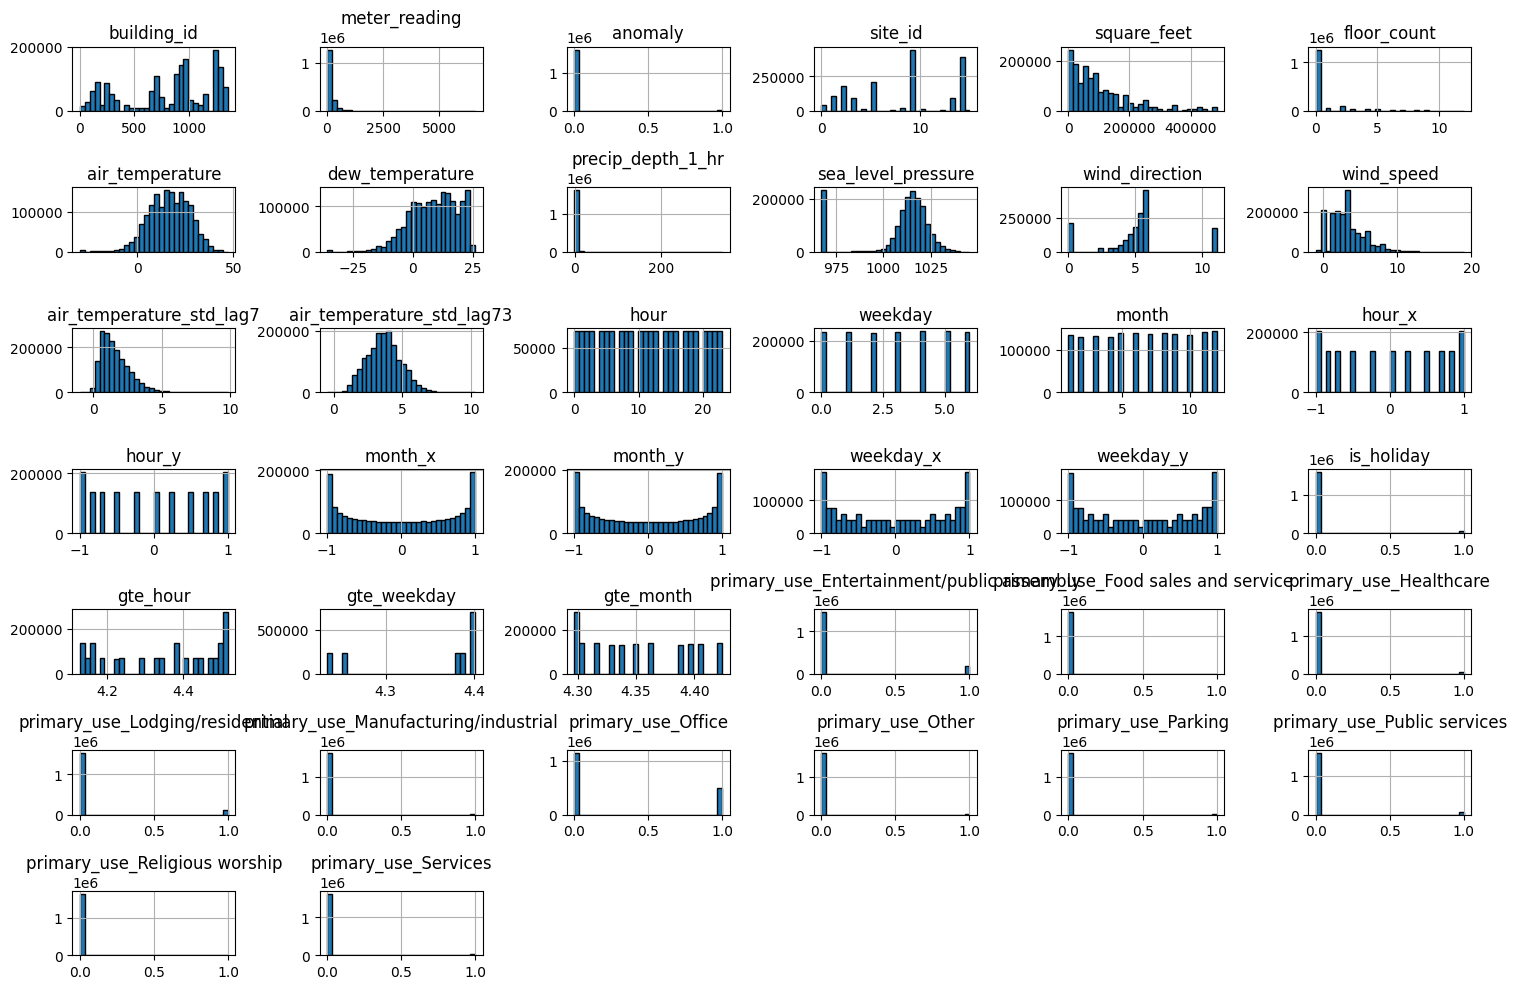

In [49]:
df.hist(bins=30, figsize=(15, 10), edgecolor='black')
plt.tight_layout()
plt.show()

In [50]:
print(df.columns)

Index(['building_id', 'meter_reading', 'anomaly', 'site_id', 'square_feet',
       'floor_count', 'air_temperature', 'dew_temperature',
       'precip_depth_1_hr', 'sea_level_pressure', 'wind_direction',
       'wind_speed', 'air_temperature_std_lag7', 'air_temperature_std_lag73',
       'hour', 'weekday', 'month', 'hour_x', 'hour_y', 'month_x', 'month_y',
       'weekday_x', 'weekday_y', 'is_holiday', 'gte_hour', 'gte_weekday',
       'gte_month', 'primary_use_Entertainment/public assembly',
       'primary_use_Food sales and service', 'primary_use_Healthcare',
       'primary_use_Lodging/residential',
       'primary_use_Manufacturing/industrial', 'primary_use_Office',
       'primary_use_Other', 'primary_use_Parking',
       'primary_use_Public services', 'primary_use_Religious worship',
       'primary_use_Services'],
      dtype='object')


Some features like `building_id`, `site_id`, `hour`, `weekday`, `month`, `hour_x`, `hour_y`, `month_x`, `month_y`, `weekday_x`, `weekday_y`, `is_holiday`, `gte_hour`, `gte_weekday`, `gte_month`, `floor_count` aren’t really related to if there is an anomaly in energy consumption or not. They may be useful, so we will try both using and not using them.

In [109]:
columns = ['building_id', 'site_id', 'hour', 'weekday', 'month', 'hour_x', 'hour_y', 'month_x', 'month_y',
       'weekday_x', 'weekday_y', 'is_holiday', 'gte_hour', 'gte_weekday', 'gte_month', 'floor_count']

df.drop(columns=columns, inplace=True)

In [110]:
print(df.shape)

(1641841, 22)


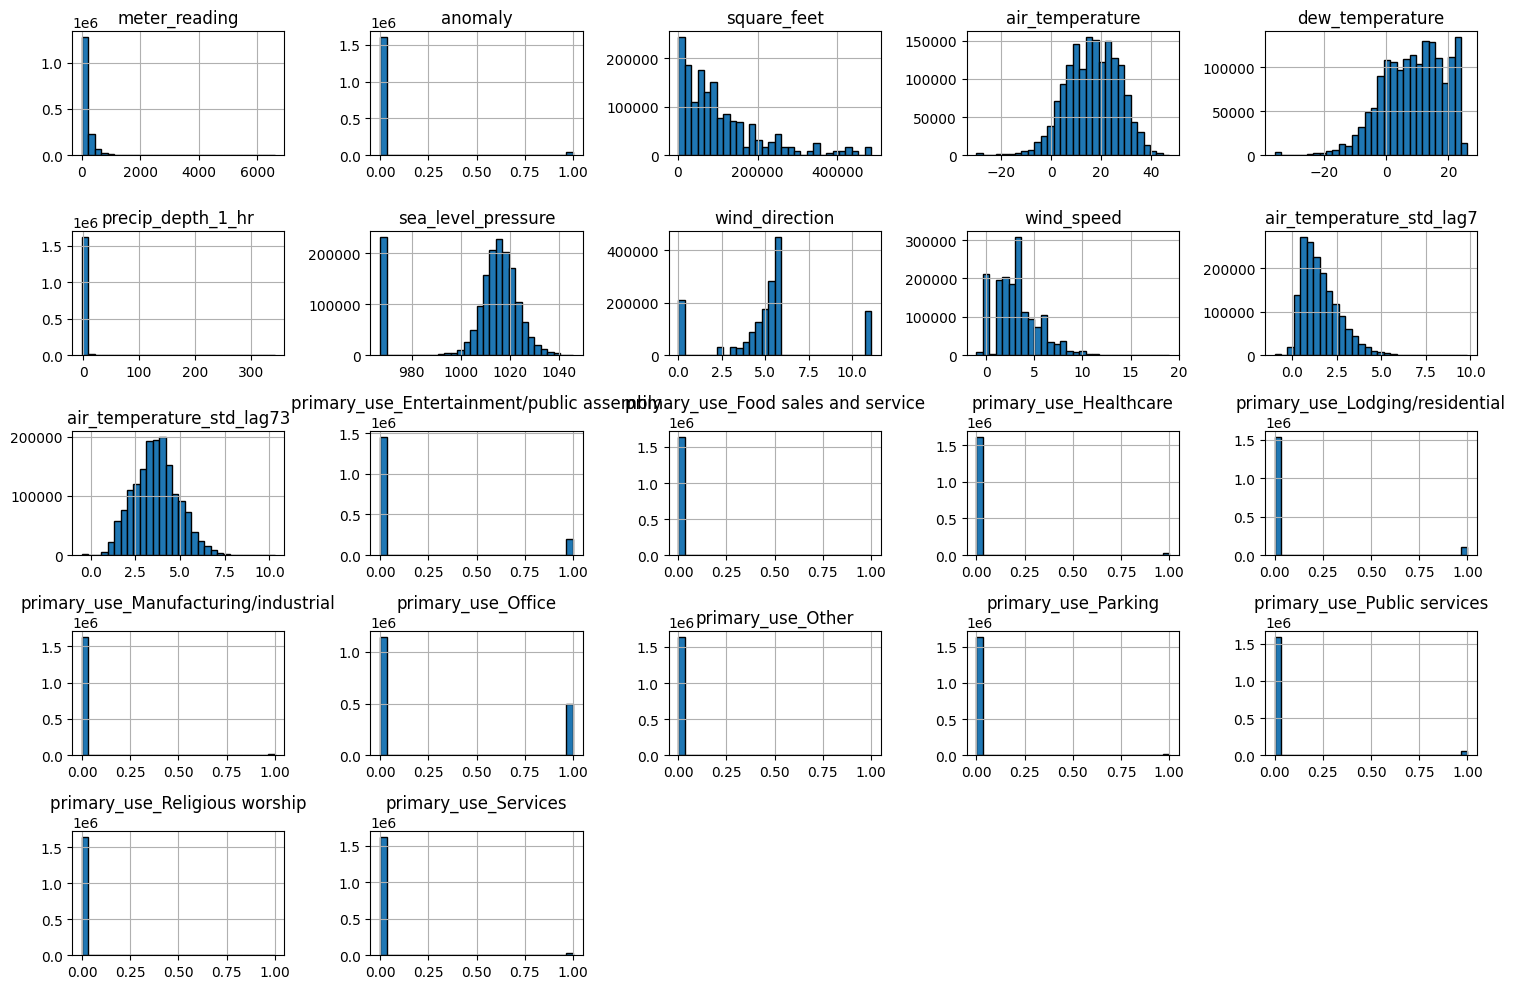

In [57]:
df.hist(bins=30, figsize=(15, 10), edgecolor='black')
plt.tight_layout()
plt.show()

array([[<Axes: title={'center': 'meter_reading'}>,
        <Axes: title={'center': 'precip_depth_1_hr'}>]], dtype=object)

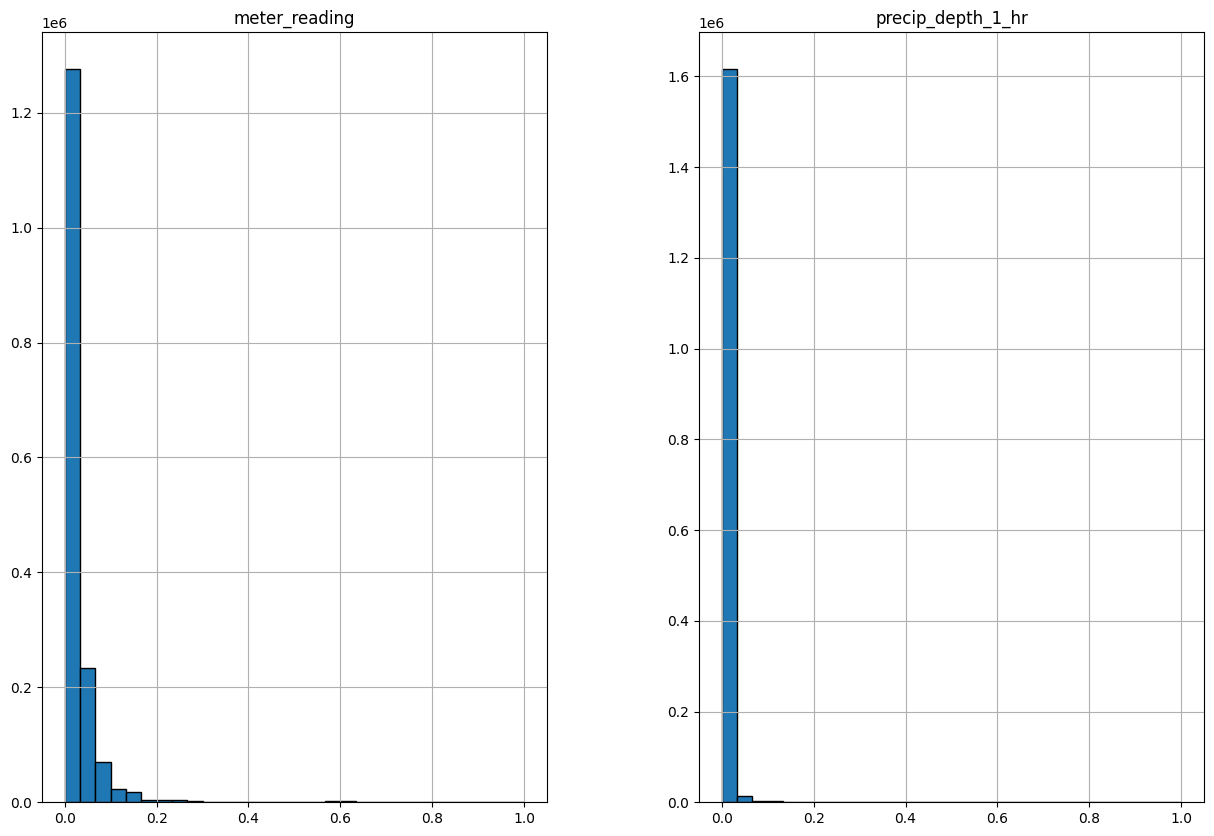

In [79]:
scaler = MinMaxScaler()
columns = ['meter_reading', 'precip_depth_1_hr']
df[columns] = scaler.fit_transform(df[columns])
df.hist(column=columns, bins=30, figsize=(15, 10), edgecolor='black')

898 -1.0


array([[<Axes: title={'center': 'square_feet'}>,
        <Axes: title={'center': 'wind_speed'}>]], dtype=object)

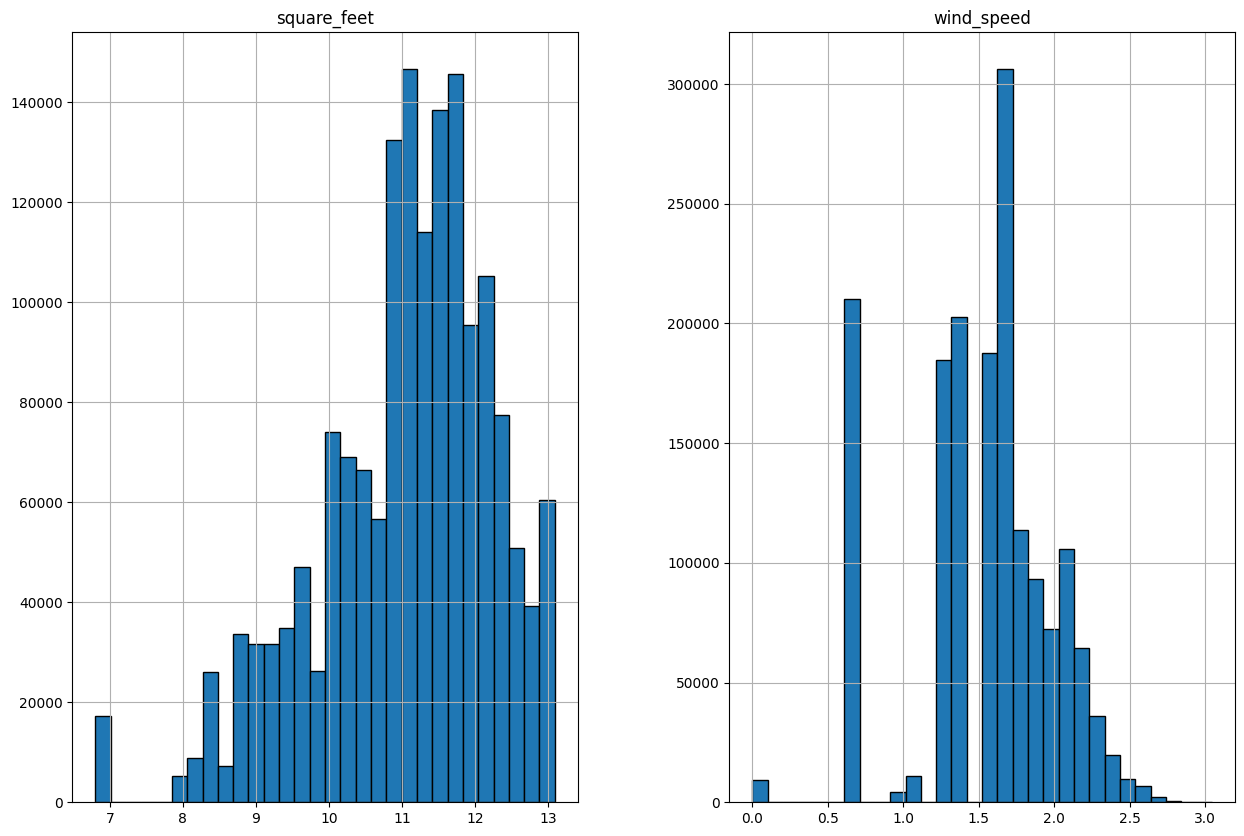

In [85]:
columns = ['square_feet', 'wind_speed']
print(df['square_feet'].min(), df['wind_speed'].min())
df[columns] = np.log1p(df[columns] - np.min(df[columns].min(), 0))
df[columns].hist(column=columns, bins=30, figsize=(15, 10), edgecolor='black')

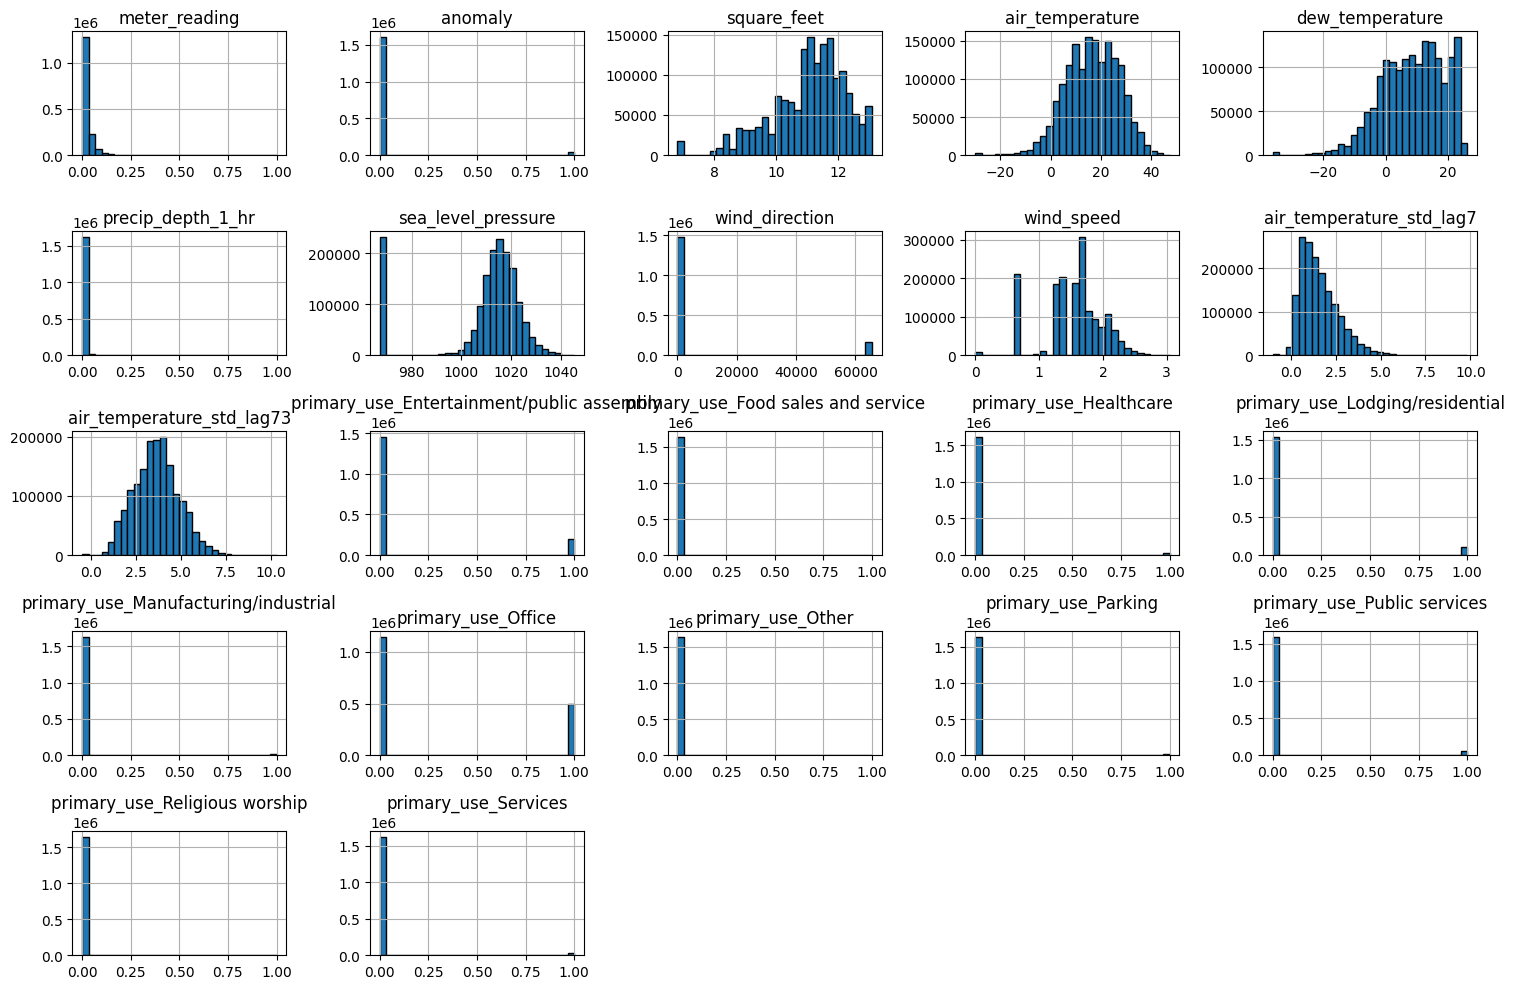

In [86]:
df.hist(bins=30, figsize=(15, 10), edgecolor='black')
plt.tight_layout()
plt.show()

### Saving Dataset

In [87]:
saveDataset(file_path='Dataset/cleaned.csv')

In [88]:
df = pd.read_csv('Dataset/cleaned.csv')
print(df.shape, '\n')
print(df.dtypes, '\n')
print(df.head())

(1641841, 22) 

meter_reading                                float64
anomaly                                        int64
square_feet                                  float64
air_temperature                              float64
dew_temperature                              float64
precip_depth_1_hr                            float64
sea_level_pressure                           float64
wind_direction                                 int64
wind_speed                                   float64
air_temperature_std_lag7                     float64
air_temperature_std_lag73                    float64
primary_use_Entertainment/public assembly      int64
primary_use_Food sales and service             int64
primary_use_Healthcare                         int64
primary_use_Lodging/residential                int64
primary_use_Manufacturing/industrial           int64
primary_use_Office                             int64
primary_use_Other                              int64
primary_use_Parking           